This does not have a reward for each individual turn. Just plays out d cycles of turns and uses the evaluation function at end.

In [1]:
from utils.game_map_class import GameMap
from utils.game_team_class import GameTeam
from utils.strategy_class import Strategy, RandomStrategy, RuleOfThumbStrategy
from utils.map_setup_functions import setGameBoardRandom, initializeFullRiskMap
from utils.heuristics import BST_Heuristic, EdgeWin

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
import copy

In [4]:
def rollout_lookahead(team,riskMap,d,discount):
    '''Returns the best action according to lookahead with rollouts'''
    return greedy(team,riskMap,d,discount)[0]

In [5]:
def greedy(team,riskMap,d,discount):
    '''Greedily looks through all possible actions and determines the value of each from the current state
    using lookahead with rollouts. Returns action with maximum value and the value itself'''
    possible_attackers = team.getPossibleAttacks()
    print(possible_attackers)
    lookahead_list = []
    for attacker in possible_attackers:
        for defender in possible_attackers[attacker]:
            action = (attacker,defender)
            u = lookahead(discount,riskMap,action,d)
            lookahead_list.append((action,u))
    print(lookahead_list)
    if len(lookahead_list) == 0:
        return (None,None)
    return max(lookahead_list, key = lambda x: x[1])

In [6]:
def lookahead(discount,riskMap,action,d):
    ''' Computes successor states and probabilities of these successor states given the current riskMap
    
    Then for each of these successor states performs a rollout to get a value that that successor state and 
    multiplies it by the probability of that successor state. Takes the sum of those values and multiplies it
    by the discount factor to return the value of that function.
    '''
    
    # Gets basic information about current state of play
    attacking_territory, defending_territory = action
    num_attackers = riskMap.getTroops(attacking_territory)
    num_defenders = riskMap.getTroops(defending_territory)
    
    # Computes successor states and transition probabilities
    succ_state_probs = {}
    compute_succ_state_prob(1,num_attackers,num_defenders,succ_state_probs)
    
    sum_successors = 0
    for succ in succ_state_probs:
        
        # Sets up successor state
        sp = copy.deepcopy(riskMap)
        # Doing a deepcopy of the riskMap also makes copies of the GameTeams stored within the map in riskMap.teams
        # so we don't have to make another copy
        attacking_team = sp.getTeam(attacking_territory)
        defending_team = sp.getTeam(defending_territory)
        set_up_sp(sp,succ,attacking_team,defending_team,attacking_territory,defending_territory)
        
        # Gets value of successor state via rollout and multiplies by the transition probability to add to sum
        prob = succ_state_probs[succ]
        sum_successors += prob*rollout(discount,sp,d,attacking_team,defending_team)
        
    return discount*sum_successors

In [7]:
def compute_succ_state_prob(prob,num_attackers,num_defenders,succ_state_probs):
    """This recursive function run to completion is meant to take prob = 1 and a number of attackers
    and defenders for a battle and update the succ_state_probs dictionary with the possible outcomes mapped
    to their respective probabilities."""
    if num_attackers == 0 or num_attackers == 1 or num_defenders == 0:
        if (num_attackers,num_defenders) in succ_state_probs:
            succ_state_probs[(num_attackers,num_defenders)] += prob
        else:
            succ_state_probs[(num_attackers,num_defenders)] = prob
    if num_attackers == 2 and num_defenders == 1:
        compute_succ_state_prob(prob*5/12,num_attackers, num_defenders - 1,succ_state_probs)
        compute_succ_state_prob(prob*7/12,num_attackers - 1, num_defenders,succ_state_probs)
    if num_attackers == 3 and num_defenders == 1:
        compute_succ_state_prob(prob*125/216,num_attackers,num_defenders - 1,succ_state_probs)
        compute_succ_state_prob(prob*91/216,num_attackers - 1,num_defenders,succ_state_probs)
    if num_attackers > 3 and num_defenders == 1:
        compute_succ_state_prob(prob*95/144,num_attackers, num_defenders - 1,succ_state_probs)
        compute_succ_state_prob(prob*49/144,num_attackers - 1, num_defenders,succ_state_probs)
    if num_attackers == 2 and num_defenders > 1:
        compute_succ_state_prob(prob*55/216,num_attackers, num_defenders - 1,succ_state_probs)
        compute_succ_state_prob(prob*161/216,num_attackers - 1, num_defenders,succ_state_probs)
    if num_attackers == 3 and num_defenders > 1:
        compute_succ_state_prob(prob*295/1296,num_attackers, num_defenders - 2,succ_state_probs)
        compute_succ_state_prob(prob*35/108,num_attackers - 1, num_defenders - 1,succ_state_probs)
        compute_succ_state_prob(prob*581/1296,num_attackers - 2, num_defenders,succ_state_probs)
    if num_attackers > 3 and num_defenders > 1:
        compute_succ_state_prob(prob*1445/3888,num_attackers, num_defenders - 2,succ_state_probs)
        compute_succ_state_prob(prob*2611/7776,num_attackers - 1, num_defenders - 1,succ_state_probs)
        compute_succ_state_prob(prob*2275/7776,num_attackers - 2, num_defenders,succ_state_probs)

In [8]:
def set_up_sp(sp,succ,attacking_team,defending_team,attacking_territory,defending_territory):
    '''Sets up a successor state'''
    succ_num_attackers, succ_num_defenders = succ

    attacking_team.setTroops(attacking_territory, succ_num_attackers)
    defending_team.setTroops(defending_territory, succ_num_defenders)

    # Do not need to consider succ_num_attackers == 1 because we've already set the number of troops to be 1 above
    
    if succ_num_defenders == 0:

        # Declare the territory to the attacking team! 
        sp.setTeam(defending_territory, attacking_team.name)
        # Assign the territory to the attacking team
        attacking_team.addTerritory(defending_territory)
        defending_team.removeTerritory(defending_territory)

        # Move all but one remaining attacking troops to the territory
        attacking_team.moveTroops(attacking_territory, defending_territory, succ_num_attackers - 1)

In [9]:
def rollout(discount,sp,d,my_team,opponent):
    '''Rolls out using a stochastic policy (this is encoded in the strategy of my_team itself) against player. 
    Repeats rounds of turns to depth. If my_team wins, the reward is 100. If the opponent wins, the reward is 0.
    Otherwise, at the end of the rollout, we use the BST heuristic for both teams and the reward. We see what percentage
    of BTS between the two teams is attributed to the opponent (would be good for my_team) and use that as the reward'''
    ret = 0
    end_reached = False
    for t in range(d):
        if my_team.hasTeamWon():
            r = 100
            return (discount**t)*r
        opponent.playTurn()
        if opponent.hasTeamWon():
            r = -1
            return (discount**t)*r
        my_team.playTurn()
    if my_team.hasTeamWon():
        r = 100
        return (discount**(d-1))*r
    elif opponent.hasTeamWon():
        r = -1
        return (discount**(d-1))*r
    else:
        #print(BST_Heuristic(my_team,sp))
        #BST_my_team_sum = sum(list(BST_Heuristic(my_team,sp).values()))
        #BST_opponent_sum = sum(list(BST_Heuristic(opponent,sp).values()))
        #r = 100*BST_opponent_sum/(BST_my_team_sum+BST_opponent_sum)
        r = 100*EdgeWin(my_team,sp)
        return (discount**(d-1))*r

In [10]:
full_risk_map = initializeFullRiskMap()
team_names = ["rollout_team","rollout_opponent"]
team_strategies = [RandomStrategy,RuleOfThumbStrategy]
risk_map, teams = setGameBoardRandom(team_names, full_risk_map, team_strategies)
teams[1].getPossibleAttacks()

{}

Adding 1 to Eastern United States!
Adding 1 to Western Europe!
Adding 1 to Southern Europe!
Adding 1 to Congo!
Adding 1 to Siberia!
Adding 1 to Brazil!
Adding 1 to Northern Europe!
('Siberia', ['Yakutsk', 'Irkutsk', 'China'])
('Siberia', 'Yakutsk')
Team rollout_team declares attack on Team rollout_opponent from Siberia to Yakutsk
Attacking_dice:  [1]
Defending_dice:  [1]
[False]
Attacking Troops Left:  1
Defending Troops Left:  1
('Southern Europe', ['Ukraine', 'Middle East'])
('Southern Europe', 'Middle East')
Team rollout_team declares attack on Team rollout_opponent from Southern Europe to Middle East
Attacking_dice:  [3]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  2
Defending Troops Left:  0
('Brazil', ['Peru', 'Argentina'])
('Brazil', 'Argentina')
Team rollout_team declares attack on Team rollout_opponent from Brazil to Argentina
Attacking_dice:  [6]
Defending_dice:  [2]
[ True]
Attacking Troops Left:  2
Defending Troops Left:  0
('Northern Europe', ['Ukraine'])
('Norther

/Users/janieboettcher/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


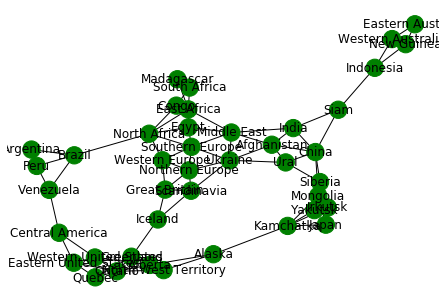

In [11]:
curr_team = teams[0]
defending_team = teams[1]
counter = 0
while len(teams[0].getPossibleAttacks())==0:
    curr_team.playTurn()
    curr_team_temp = curr_team
    curr_team = defending_team
    defending_team = curr_team_temp
    color_map = risk_map.getTeamColorMap()
    nx.draw(risk_map.graph, node_color = color_map, with_labels=True)
    plt.show()
    counter += 1

In [12]:
teams[0].getPossibleAttacks()

{'Congo': ['East Africa'],
 'Eastern United States': ['Ontario',
  'Quebec',
  'Western United States',
  'Central America']}

In [13]:
rollout_lookahead(teams[0],risk_map,30,.95)

{'Congo': ['East Africa'], 'Eastern United States': ['Ontario', 'Quebec', 'Western United States', 'Central America']}
Adding 5 to Peru!
('Peru', 'Brazil')
Team rollout_opponent declares attack on Team rollout_team from Peru to Brazil
Attacking_dice:  [6, 2, 1]
Defending_dice:  [4]
[ True]
Attacking Troops Left:  6
Defending Troops Left:  0
('Brazil', 'Argentina')
Team rollout_opponent declares attack on Team rollout_team from Brazil to Argentina
Attacking_dice:  [6, 2, 1]
Defending_dice:  [2]
[ True]
Attacking Troops Left:  5
Defending Troops Left:  0
Adding 1 to Siberia!
Adding 1 to Southern Europe!
Adding 1 to Ural!
Adding 1 to Kamchatka!
Adding 1 to Kamchatka!
Adding 1 to East Africa!
Adding 1 to Middle East!
('Siberia', ['Yakutsk', 'Irkutsk', 'China'])
('Siberia', 'Yakutsk')
Team rollout_team declares attack on Team rollout_opponent from Siberia to Yakutsk
Attacking_dice:  [4]
Defending_dice:  [6]
[False]
Attacking Troops Left:  1
Defending Troops Left:  1
('Ural', ['Afghanistan',

Attacking Troops Left:  6
Defending Troops Left:  1
Attacking_dice:  [4, 3, 2]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  6
Defending Troops Left:  0
('Northern Europe', ['Great Britain', 'Scandinavia', 'Southern Europe', 'Ukraine'])
Adding 12 to Mongolia!
('Mongolia', 'Kamchatka')
Team rollout_opponent declares attack on Team rollout_team from Mongolia to Kamchatka
Attacking_dice:  [6, 3, 2]
Defending_dice:  [5]
[ True]
Attacking Troops Left:  13
Defending Troops Left:  0
('Kamchatka', 'Japan')
Team rollout_opponent declares attack on Team rollout_team from Kamchatka to Japan
Attacking_dice:  [5, 4, 2]
Defending_dice:  [4, 3]
[ True  True]
Attacking Troops Left:  12
Defending Troops Left:  0
Adding 1 to Irkutsk!
Adding 1 to Venezuela!
Adding 1 to Western Europe!
('Irkutsk', ['Siberia', 'Yakutsk', 'Kamchatka', 'Mongolia'])
('Irkutsk', 'Siberia')
Team rollout_team declares attack on Team rollout_opponent from Irkutsk to Siberia
Attacking_dice:  [6, 2]
Defending_dice:  [4]
[ Tr

Defending_dice:  [1]
[ True]
Attacking Troops Left:  2
Defending Troops Left:  0
('Ural', ['Afghanistan', 'China'])
('Ural', 'China')
Team rollout_team declares attack on Team rollout_opponent from Ural to China
Attacking_dice:  [4, 2]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  3
Defending Troops Left:  0
('Kamchatka', ['Yakutsk', 'Irkutsk', 'Japan'])
('Kamchatka', 'Japan')
Team rollout_team declares attack on Team rollout_opponent from Kamchatka to Japan
Attacking_dice:  [1]
Defending_dice:  [5]
[False]
Attacking Troops Left:  1
Defending Troops Left:  1
('China', ['Afghanistan', 'Siam', 'India'])
('China', 'India')
Team rollout_team declares attack on Team rollout_opponent from China to India
Attacking_dice:  [3]
Defending_dice:  [3]
[False]
Attacking Troops Left:  1
Defending Troops Left:  1
('Middle East', ['Egypt', 'East Africa', 'Afghanistan', 'India'])
Adding 6 to Afghanistan!
('Afghanistan', 'China')
Team rollout_opponent declares attack on Team rollout_team from Afgh

[False]
Attacking Troops Left:  3
Defending Troops Left:  1
Attacking_dice:  [4, 1]
Defending_dice:  [6]
[False]
Attacking Troops Left:  2
Defending Troops Left:  1
Attacking_dice:  [1]
Defending_dice:  [1]
[False]
Attacking Troops Left:  1
Defending Troops Left:  1
('Iceland', ['Greenland'])
('Iceland', 'Greenland')
Team rollout_team declares attack on Team rollout_opponent from Iceland to Greenland
Attacking_dice:  [4]
Defending_dice:  [3]
[ True]
Attacking Troops Left:  2
Defending Troops Left:  0
('Kamchatka', ['Yakutsk', 'Irkutsk', 'Mongolia'])
('Kamchatka', 'Mongolia')
Team rollout_team declares attack on Team rollout_opponent from Kamchatka to Mongolia
Attacking_dice:  [6]
Defending_dice:  [4]
[ True]
Attacking Troops Left:  2
Defending Troops Left:  0
('Southern Europe', ['Middle East', 'Egypt'])
Adding 8 to Siberia!
('Siberia', 'Mongolia')
Team rollout_opponent declares attack on Team rollout_team from Siberia to Mongolia
Attacking_dice:  [6, 5, 1]
Defending_dice:  [3]
[ True]

Attacking Troops Left:  7
Defending Troops Left:  0
('Middle East', 'Egypt')
Team rollout_opponent declares attack on Team rollout_team from Middle East to Egypt
Attacking_dice:  [5, 4, 1]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  6
Defending Troops Left:  0
('Egypt', 'Southern Europe')
Team rollout_opponent declares attack on Team rollout_team from Egypt to Southern Europe
Attacking_dice:  [4, 3, 1]
Defending_dice:  [5]
[False]
Attacking Troops Left:  4
Defending Troops Left:  1
Attacking_dice:  [6, 4, 1]
Defending_dice:  [5]
[ True]
Attacking Troops Left:  4
Defending Troops Left:  0
('Southern Europe', 'Ukraine')
Team rollout_opponent declares attack on Team rollout_team from Southern Europe to Ukraine
Attacking_dice:  [4, 1]
Defending_dice:  [2]
[ True]
Attacking Troops Left:  3
Defending Troops Left:  0
('Ukraine', 'Scandinavia')
Team rollout_opponent declares attack on Team rollout_team from Ukraine to Scandinavia
Attacking_dice:  [5]
Defending_dice:  [2]
[ True]
Attac

Defending Troops Left:  1
Attacking_dice:  [6, 4, 3]
Defending_dice:  [4]
[ True]
Attacking Troops Left:  7
Defending Troops Left:  0
('China', 'Ural')
Team rollout_opponent declares attack on Team rollout_team from China to Ural
Attacking_dice:  [6, 4, 3]
Defending_dice:  [5]
[ True]
Attacking Troops Left:  6
Defending Troops Left:  0
('Ural', 'Siberia')
Team rollout_opponent declares attack on Team rollout_team from Ural to Siberia
Attacking_dice:  [6, 4, 1]
Defending_dice:  [5, 2]
[ True  True]
Attacking Troops Left:  5
Defending Troops Left:  2
Attacking_dice:  [6, 2, 1]
Defending_dice:  [4, 3]
[ True False]
Attacking Troops Left:  4
Defending Troops Left:  1
Attacking_dice:  [6, 3, 2]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  4
Defending Troops Left:  0
('Siberia', 'Irkutsk')
Team rollout_opponent declares attack on Team rollout_team from Siberia to Irkutsk
Attacking_dice:  [4, 1]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  3
Defending Troops Left:  0
Adding 1 

('China', 'Afghanistan')
Team rollout_team declares attack on Team rollout_opponent from China to Afghanistan
Attacking_dice:  [5]
Defending_dice:  [3]
[ True]
Attacking Troops Left:  2
Defending Troops Left:  0
('Ural', ['Ukraine', 'Siberia'])
Adding 12 to Irkutsk!
('Irkutsk', 'Kamchatka')
Team rollout_opponent declares attack on Team rollout_team from Irkutsk to Kamchatka
Attacking_dice:  [6, 5, 2]
Defending_dice:  [2, 1]
[ True  True]
Attacking Troops Left:  19
Defending Troops Left:  0
('Kamchatka', 'Japan')
Team rollout_opponent declares attack on Team rollout_team from Kamchatka to Japan
Attacking_dice:  [5, 4, 3]
Defending_dice:  [4]
[ True]
Attacking Troops Left:  18
Defending Troops Left:  0
Adding 1 to Ural!
Adding 1 to Ural!
Adding 1 to Afghanistan!
('Ural', ['Ukraine', 'Siberia'])
('Ural', 'Ukraine')
Team rollout_team declares attack on Team rollout_opponent from Ural to Ukraine
Attacking_dice:  [6, 3, 2]
Defending_dice:  [5]
[ True]
Attacking Troops Left:  6
Defending Troo

Defending Troops Left:  0
('Kamchatka', ['Yakutsk', 'Irkutsk'])
('Kamchatka', 'Yakutsk')
Team rollout_team declares attack on Team rollout_opponent from Kamchatka to Yakutsk
Attacking_dice:  [2]
Defending_dice:  [6]
[False]
Attacking Troops Left:  1
Defending Troops Left:  1
('Mongolia', ['Irkutsk', 'China'])
('Mongolia', 'China')
Team rollout_team declares attack on Team rollout_opponent from Mongolia to China
Attacking_dice:  [5, 2]
Defending_dice:  [5]
[False]
Attacking Troops Left:  2
Defending Troops Left:  1
Attacking_dice:  [1]
Defending_dice:  [5]
[False]
Attacking Troops Left:  1
Defending Troops Left:  1
('Western Europe', ['Northern Europe', 'Southern Europe', 'North Africa'])
('Western Europe', 'Northern Europe')
Team rollout_team declares attack on Team rollout_opponent from Western Europe to Northern Europe
Attacking_dice:  [6, 4, 2]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  4
Defending Troops Left:  0
('Great Britain', ['Iceland', 'Scandinavia'])
('Great Brita

('Indonesia', 'New Guinea')
Team rollout_opponent declares attack on Team rollout_team from Indonesia to New Guinea
Attacking_dice:  [5, 3, 1]
Defending_dice:  [6, 1]
[False  True]
Attacking Troops Left:  9
Defending Troops Left:  3
Attacking_dice:  [6, 5, 3]
Defending_dice:  [4, 3]
[ True  True]
Attacking Troops Left:  9
Defending Troops Left:  1
Attacking_dice:  [5, 4, 1]
Defending_dice:  [4]
[ True]
Attacking Troops Left:  9
Defending Troops Left:  0
('New Guinea', 'Eastern Australia')
Team rollout_opponent declares attack on Team rollout_team from New Guinea to Eastern Australia
Attacking_dice:  [4, 3, 2]
Defending_dice:  [5, 1]
[False  True]
Attacking Troops Left:  7
Defending Troops Left:  2
Attacking_dice:  [6, 5, 1]
Defending_dice:  [6, 2]
[False  True]
Attacking Troops Left:  6
Defending Troops Left:  1
Attacking_dice:  [6, 5, 4]
Defending_dice:  [6]
[False]
Attacking Troops Left:  5
Defending Troops Left:  1
Attacking_dice:  [6, 4, 1]
Defending_dice:  [5]
[ True]
Attacking Tr

Attacking Troops Left:  3
Defending Troops Left:  0
('Quebec', ['Ontario'])
('Quebec', 'Ontario')
Team rollout_team declares attack on Team rollout_opponent from Quebec to Ontario
Attacking_dice:  [3]
Defending_dice:  [5]
[False]
Attacking Troops Left:  1
Defending Troops Left:  1
('Eastern Australia', ['New Guinea'])
Adding 5 to Ontario!
('Ontario', 'Greenland')
Team rollout_opponent declares attack on Team rollout_team from Ontario to Greenland
Attacking_dice:  [6, 5, 3]
Defending_dice:  [3]
[ True]
Attacking Troops Left:  6
Defending Troops Left:  0
('Greenland', 'Quebec')
Team rollout_opponent declares attack on Team rollout_team from Greenland to Quebec
Attacking_dice:  [4, 3, 1]
Defending_dice:  [2]
[ True]
Attacking Troops Left:  5
Defending Troops Left:  0
('Quebec', 'Eastern United States')
Team rollout_opponent declares attack on Team rollout_team from Quebec to Eastern United States
Attacking_dice:  [5, 3, 1]
Defending_dice:  [2]
[ True]
Attacking Troops Left:  4
Defending T

Team rollout_team declares attack on Team rollout_opponent from China to Siam
Attacking_dice:  [3, 2]
Defending_dice:  [5]
[False]
Attacking Troops Left:  2
Defending Troops Left:  1
Attacking_dice:  [1]
Defending_dice:  [5]
[False]
Attacking Troops Left:  1
Defending Troops Left:  1
('Scandinavia', ['Great Britain', 'Ukraine'])
('Scandinavia', 'Ukraine')
Team rollout_team declares attack on Team rollout_opponent from Scandinavia to Ukraine
Attacking_dice:  [6, 4]
Defending_dice:  [5]
[ True]
Attacking Troops Left:  3
Defending Troops Left:  0
('Ukraine', ['Southern Europe', 'Ural', 'Afghanistan', 'Middle East'])
('Ukraine', 'Ural')
Team rollout_team declares attack on Team rollout_opponent from Ukraine to Ural
Attacking_dice:  [4]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  2
Defending Troops Left:  0
('Greenland', ['Ontario', 'Quebec'])
('Greenland', 'Quebec')
Team rollout_team declares attack on Team rollout_opponent from Greenland to Quebec
Attacking_dice:  [5, 2]
Defendin

('Great Britain', 'Western Europe')
Team rollout_team declares attack on Team rollout_opponent from Great Britain to Western Europe
Attacking_dice:  [3, 2]
Defending_dice:  [2]
[ True]
Attacking Troops Left:  3
Defending Troops Left:  0
('Western Europe', ['Southern Europe'])
Adding 8 to Southern Europe!
('Southern Europe', 'Northern Europe')
Team rollout_opponent declares attack on Team rollout_team from Southern Europe to Northern Europe
Attacking_dice:  [6, 3, 1]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  9
Defending Troops Left:  0
('Northern Europe', 'Ukraine')
Team rollout_opponent declares attack on Team rollout_team from Northern Europe to Ukraine
Attacking_dice:  [5, 4, 1]
Defending_dice:  [4]
[ True]
Attacking Troops Left:  8
Defending Troops Left:  0
('Ukraine', 'Scandinavia')
Team rollout_opponent declares attack on Team rollout_team from Ukraine to Scandinavia
Attacking_dice:  [5, 2, 1]
Defending_dice:  [2]
[ True]
Attacking Troops Left:  7
Defending Troops Left:

Attacking_dice:  [4, 2]
Defending_dice:  [3]
[ True]
Attacking Troops Left:  3
Defending Troops Left:  0
('Argentina', ['Peru'])
('Argentina', 'Peru')
Team rollout_team declares attack on Team rollout_opponent from Argentina to Peru
Attacking_dice:  [3]
Defending_dice:  [3]
[False]
Attacking Troops Left:  1
Defending Troops Left:  1
('Western Australia', ['Indonesia', 'New Guinea'])
('Western Australia', 'Indonesia')
Team rollout_team declares attack on Team rollout_opponent from Western Australia to Indonesia
Attacking_dice:  [6, 4]
Defending_dice:  [4]
[ True]
Attacking Troops Left:  3
Defending Troops Left:  0
('North Africa', ['Southern Europe', 'East Africa', 'Congo'])
('North Africa', 'Congo')
Team rollout_team declares attack on Team rollout_opponent from North Africa to Congo
Attacking_dice:  [6]
Defending_dice:  [6]
[False]
Attacking Troops Left:  1
Defending Troops Left:  1
('Indonesia', ['Siam', 'New Guinea'])
Adding 7 to Southern Europe!
('Southern Europe', 'Egypt')
Team ro

[ True]
Attacking Troops Left:  3
Defending Troops Left:  0
('China', ['Afghanistan', 'Ural', 'Mongolia', 'India'])
('China', 'Ural')
Team rollout_team declares attack on Team rollout_opponent from China to Ural
Attacking_dice:  [5]
Defending_dice:  [4]
[ True]
Attacking Troops Left:  2
Defending Troops Left:  0
('Siberia', ['Yakutsk', 'Irkutsk', 'Mongolia'])
Adding 11 to India!
('India', 'China')
Team rollout_opponent declares attack on Team rollout_team from India to China
Attacking_dice:  [6, 3, 1]
Defending_dice:  [3]
[ True]
Attacking Troops Left:  12
Defending Troops Left:  0
('China', 'Ural')
Team rollout_opponent declares attack on Team rollout_team from China to Ural
Attacking_dice:  [6, 3, 1]
Defending_dice:  [2]
[ True]
Attacking Troops Left:  11
Defending Troops Left:  0
('Ural', 'Siberia')
Team rollout_opponent declares attack on Team rollout_team from Ural to Siberia
Attacking_dice:  [6, 3, 1]
Defending_dice:  [5, 1]
[ True  True]
Attacking Troops Left:  10
Defending Troo

('Eastern United States', 'Central America')
Team rollout_team declares attack on Team rollout_opponent from Eastern United States to Central America
Attacking_dice:  [6]
Defending_dice:  [3]
[ True]
Attacking Troops Left:  2
Defending Troops Left:  0
('Ontario', ['North West Territory', 'Alberta', 'Greenland', 'Quebec'])
('Ontario', 'Quebec')
Team rollout_team declares attack on Team rollout_opponent from Ontario to Quebec
Attacking_dice:  [3, 2, 1]
Defending_dice:  [3]
[False]
Attacking Troops Left:  3
Defending Troops Left:  1
Attacking_dice:  [4, 3]
Defending_dice:  [2]
[ True]
Attacking Troops Left:  3
Defending Troops Left:  0
('Eastern Australia', ['New Guinea'])
Adding 6 to Greenland!
('Greenland', 'Ontario')
Team rollout_opponent declares attack on Team rollout_team from Greenland to Ontario
Attacking_dice:  [6, 4, 2]
Defending_dice:  [5]
[ True]
Attacking Troops Left:  7
Defending Troops Left:  0
('Ontario', 'Eastern United States')
Team rollout_opponent declares attack on Te

Attacking_dice:  [6, 5, 1]
Defending_dice:  [5]
[ True]
Attacking Troops Left:  7
Defending Troops Left:  0
('Northern Europe', 'Western Europe')
Team rollout_opponent declares attack on Team rollout_team from Northern Europe to Western Europe
Attacking_dice:  [5, 2, 1]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  6
Defending Troops Left:  0
('Western Europe', 'Great Britain')
Team rollout_opponent declares attack on Team rollout_team from Western Europe to Great Britain
Attacking_dice:  [4, 3, 1]
Defending_dice:  [2]
[ True]
Attacking Troops Left:  5
Defending Troops Left:  0
('Great Britain', 'Iceland')
Team rollout_opponent declares attack on Team rollout_team from Great Britain to Iceland
Attacking_dice:  [6, 5, 4]
Defending_dice:  [4, 1]
[ True  True]
Attacking Troops Left:  4
Defending Troops Left:  0
('Iceland', 'Greenland')
Team rollout_opponent declares attack on Team rollout_team from Iceland to Greenland
Attacking_dice:  [4, 3]
Defending_dice:  [3]
[ True]
Attacking 

Attacking Troops Left:  12
Defending Troops Left:  0
('China', 'India')
Team rollout_opponent declares attack on Team rollout_team from China to India
Attacking_dice:  [5, 3, 2]
Defending_dice:  [3]
[ True]
Attacking Troops Left:  11
Defending Troops Left:  0
('India', 'Afghanistan')
Team rollout_opponent declares attack on Team rollout_team from India to Afghanistan
Attacking_dice:  [5, 4, 1]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  10
Defending Troops Left:  0
('Afghanistan', 'Middle East')
Team rollout_opponent declares attack on Team rollout_team from Afghanistan to Middle East
Attacking_dice:  [6, 4, 1]
Defending_dice:  [5, 4]
[ True False]
Attacking Troops Left:  8
Defending Troops Left:  2
Attacking_dice:  [5, 3, 2]
Defending_dice:  [5, 3]
[False False]
Attacking Troops Left:  6
Defending Troops Left:  2
Attacking_dice:  [6, 5, 3]
Defending_dice:  [5, 3]
[ True  True]
Attacking Troops Left:  6
Defending Troops Left:  0
Adding 1 to Indonesia!
Adding 1 to Siam!
Adding 

('Mongolia', 'Kamchatka')
Team rollout_opponent declares attack on Team rollout_team from Mongolia to Kamchatka
Attacking_dice:  [3]
Defending_dice:  [3]
[False]
Attacking Troops Left:  1
Defending Troops Left:  1
Adding 1 to Alaska!
Adding 1 to Western Europe!
Adding 1 to Great Britain!
Adding 1 to Middle East!
Adding 1 to Alberta!
Adding 1 to Eastern United States!
Adding 1 to Southern Europe!
('Argentina', ['Peru'])
('Argentina', 'Peru')
Team rollout_team declares attack on Team rollout_opponent from Argentina to Peru
Attacking_dice:  [1]
Defending_dice:  [2]
[False]
Attacking Troops Left:  1
Defending Troops Left:  1
('Congo', ['East Africa', 'South Africa'])
('Congo', 'South Africa')
Team rollout_team declares attack on Team rollout_opponent from Congo to South Africa
Attacking_dice:  [2]
Defending_dice:  [6]
[False]
Attacking Troops Left:  1
Defending Troops Left:  1
('Eastern United States', ['Ontario', 'Quebec', 'Western United States', 'Central America'])
('Eastern United Stat

Defending Troops Left:  1
Attacking_dice:  [5, 3, 2]
Defending_dice:  [5]
[False]
Attacking Troops Left:  10
Defending Troops Left:  1
Attacking_dice:  [6, 2, 1]
Defending_dice:  [6]
[False]
Attacking Troops Left:  9
Defending Troops Left:  1
Attacking_dice:  [5, 4, 1]
Defending_dice:  [4]
[ True]
Attacking Troops Left:  9
Defending Troops Left:  0
('New Guinea', 'Western Australia')
Team rollout_opponent declares attack on Team rollout_team from New Guinea to Western Australia
Attacking_dice:  [6, 4, 1]
Defending_dice:  [4]
[ True]
Attacking Troops Left:  8
Defending Troops Left:  0
('Western Australia', 'Eastern Australia')
Team rollout_opponent declares attack on Team rollout_team from Western Australia to Eastern Australia
Attacking_dice:  [5, 3, 1]
Defending_dice:  [6]
[False]
Attacking Troops Left:  6
Defending Troops Left:  1
Attacking_dice:  [6, 3, 1]
Defending_dice:  [5]
[ True]
Attacking Troops Left:  6
Defending Troops Left:  0
Adding 1 to Northern Europe!
Adding 1 to Scandi

Attacking_dice:  [5, 3, 2]
Defending_dice:  [6]
[False]
Attacking Troops Left:  3
Defending Troops Left:  1
Attacking_dice:  [6, 2]
Defending_dice:  [3]
[ True]
Attacking Troops Left:  3
Defending Troops Left:  0
('North West Territory', 'Alaska')
Team rollout_opponent declares attack on Team rollout_team from North West Territory to Alaska
Attacking_dice:  [4]
Defending_dice:  [6]
[False]
Attacking Troops Left:  1
Defending Troops Left:  1
Adding 1 to Venezuela!
Adding 1 to Central America!
Adding 1 to Brazil!
Adding 1 to Kamchatka!
Adding 1 to Afghanistan!
('Siberia', ['Ural', 'Yakutsk', 'Irkutsk', 'China'])
('Siberia', 'Ural')
Team rollout_team declares attack on Team rollout_opponent from Siberia to Ural
Attacking_dice:  [4]
Defending_dice:  [2]
[ True]
Attacking Troops Left:  2
Defending Troops Left:  0
('Kamchatka', ['Yakutsk', 'Irkutsk', 'Japan'])
('Kamchatka', 'Japan')
Team rollout_team declares attack on Team rollout_opponent from Kamchatka to Japan
Attacking_dice:  [5]
Defend

Attacking Troops Left:  7
Defending Troops Left:  0
('South Africa', 'Madagascar')
Team rollout_opponent declares attack on Team rollout_team from South Africa to Madagascar
Attacking_dice:  [6, 5, 1]
Defending_dice:  [6]
[False]
Attacking Troops Left:  5
Defending Troops Left:  1
Attacking_dice:  [6, 3, 1]
Defending_dice:  [3]
[ True]
Attacking Troops Left:  5
Defending Troops Left:  0
Adding 1 to Great Britain!
Adding 1 to Congo!
Adding 1 to Scandinavia!
Adding 1 to Alaska!
Adding 1 to Middle East!
Adding 1 to Middle East!
Adding 1 to Eastern Australia!
('Congo', ['East Africa', 'South Africa'])
('Congo', 'South Africa')
Team rollout_team declares attack on Team rollout_opponent from Congo to South Africa
Attacking_dice:  [6, 1]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  3
Defending Troops Left:  0
('Scandinavia', ['Iceland'])
('Scandinavia', 'Iceland')
Team rollout_team declares attack on Team rollout_opponent from Scandinavia to Iceland
Attacking_dice:  [3]
Defending_dice

('Eastern United States', 'Western United States')

In [14]:
a = {1:2,2:3}
a.values()

dict_values([2, 3])